**Neural Machine Translation**

I use this model to translate from Japanese to Vietnamese. However, language translation requires massive datasets and usually takes days of training on GPUs. So i use a small dataset to give you a quick demo on neural machine translation. This model only translate a few sentences about dog and book.

Firstly, we load the data and the library.

In [1]:
!pip install wget
import wget
wget.download('https://github.com/dautroc1/Machine-Translation/raw/main/data/train5.csv','train5.csv')
wget.download('https://github.com/dautroc1/Machine-Translation/raw/main/data/nmt.py','nmt.py')
wget.download('https://github.com/dautroc1/Machine-Translation/raw/main/data/my_model_weights.h5','my_model_weights.h5')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=6c8d97bf3be07fd49d6408559fa69e0c39dd51e1f95a47a531da28bbda25468b
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'my_model_weights.h5'

In [2]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
from nmt import *
import h5py
import random as python_random
import tensorflow as tf
from tqdm import tqdm
from babel.dates import format_date
 
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1234)

from keras.backend import manual_variable_initialization
manual_variable_initialization(True)
python_random.seed(1234)
tf.random.set_seed(1234)
import pandas as pd
import numpy as np
from keras.utils import to_categorical

Let's preprocess the data and map the raw text data into the index values. We will also use Tx = 70, Ty = 60( which we assume is the maximum length of Japanese sentence and Vietnamese sentence).

In [3]:
data = pd.read_csv("train5.csv",encoding='utf-8')
data['vietnamese'] = data['vietnamese'].str.lower()
data['japanese'] = data['japanese'].str.lower()
data['japanese'] = data['japanese'].str.replace(',', '')
data['vietnamese'] = data['vietnamese'].str.replace(',', '')

print(len(data))
data = data.drop([len(data)-1])
data.head()
dataset, japan_vocab, vietnam_vocab, inv_vietnam_vocab = load_dataset(data)
Tx = 70
Ty = 60
X, Y, Xoh, Yoh = preprocess_data(dataset, japan_vocab, vietnam_vocab, Tx, Ty)
 
print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

199
X.shape: (198, 70)
Y.shape: (198, 60)
Xoh.shape: (198, 70, 281)
Yoh.shape: (198, 60, 91)


Model  
I have defined the layers you need as global variables.

In [4]:
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)



Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights "alphas" and the hidden states "a" of the Bi-LSTM.

In [5]:
def one_step_attention(a, s_prev):
    
    s_prev = repeator(s_prev)
    concat = concatenator([a, s_prev])
    e = densor(concat)
    alphas = activator(e)
    context = dotor([alphas, a])
    return context

Implements the entire model. 

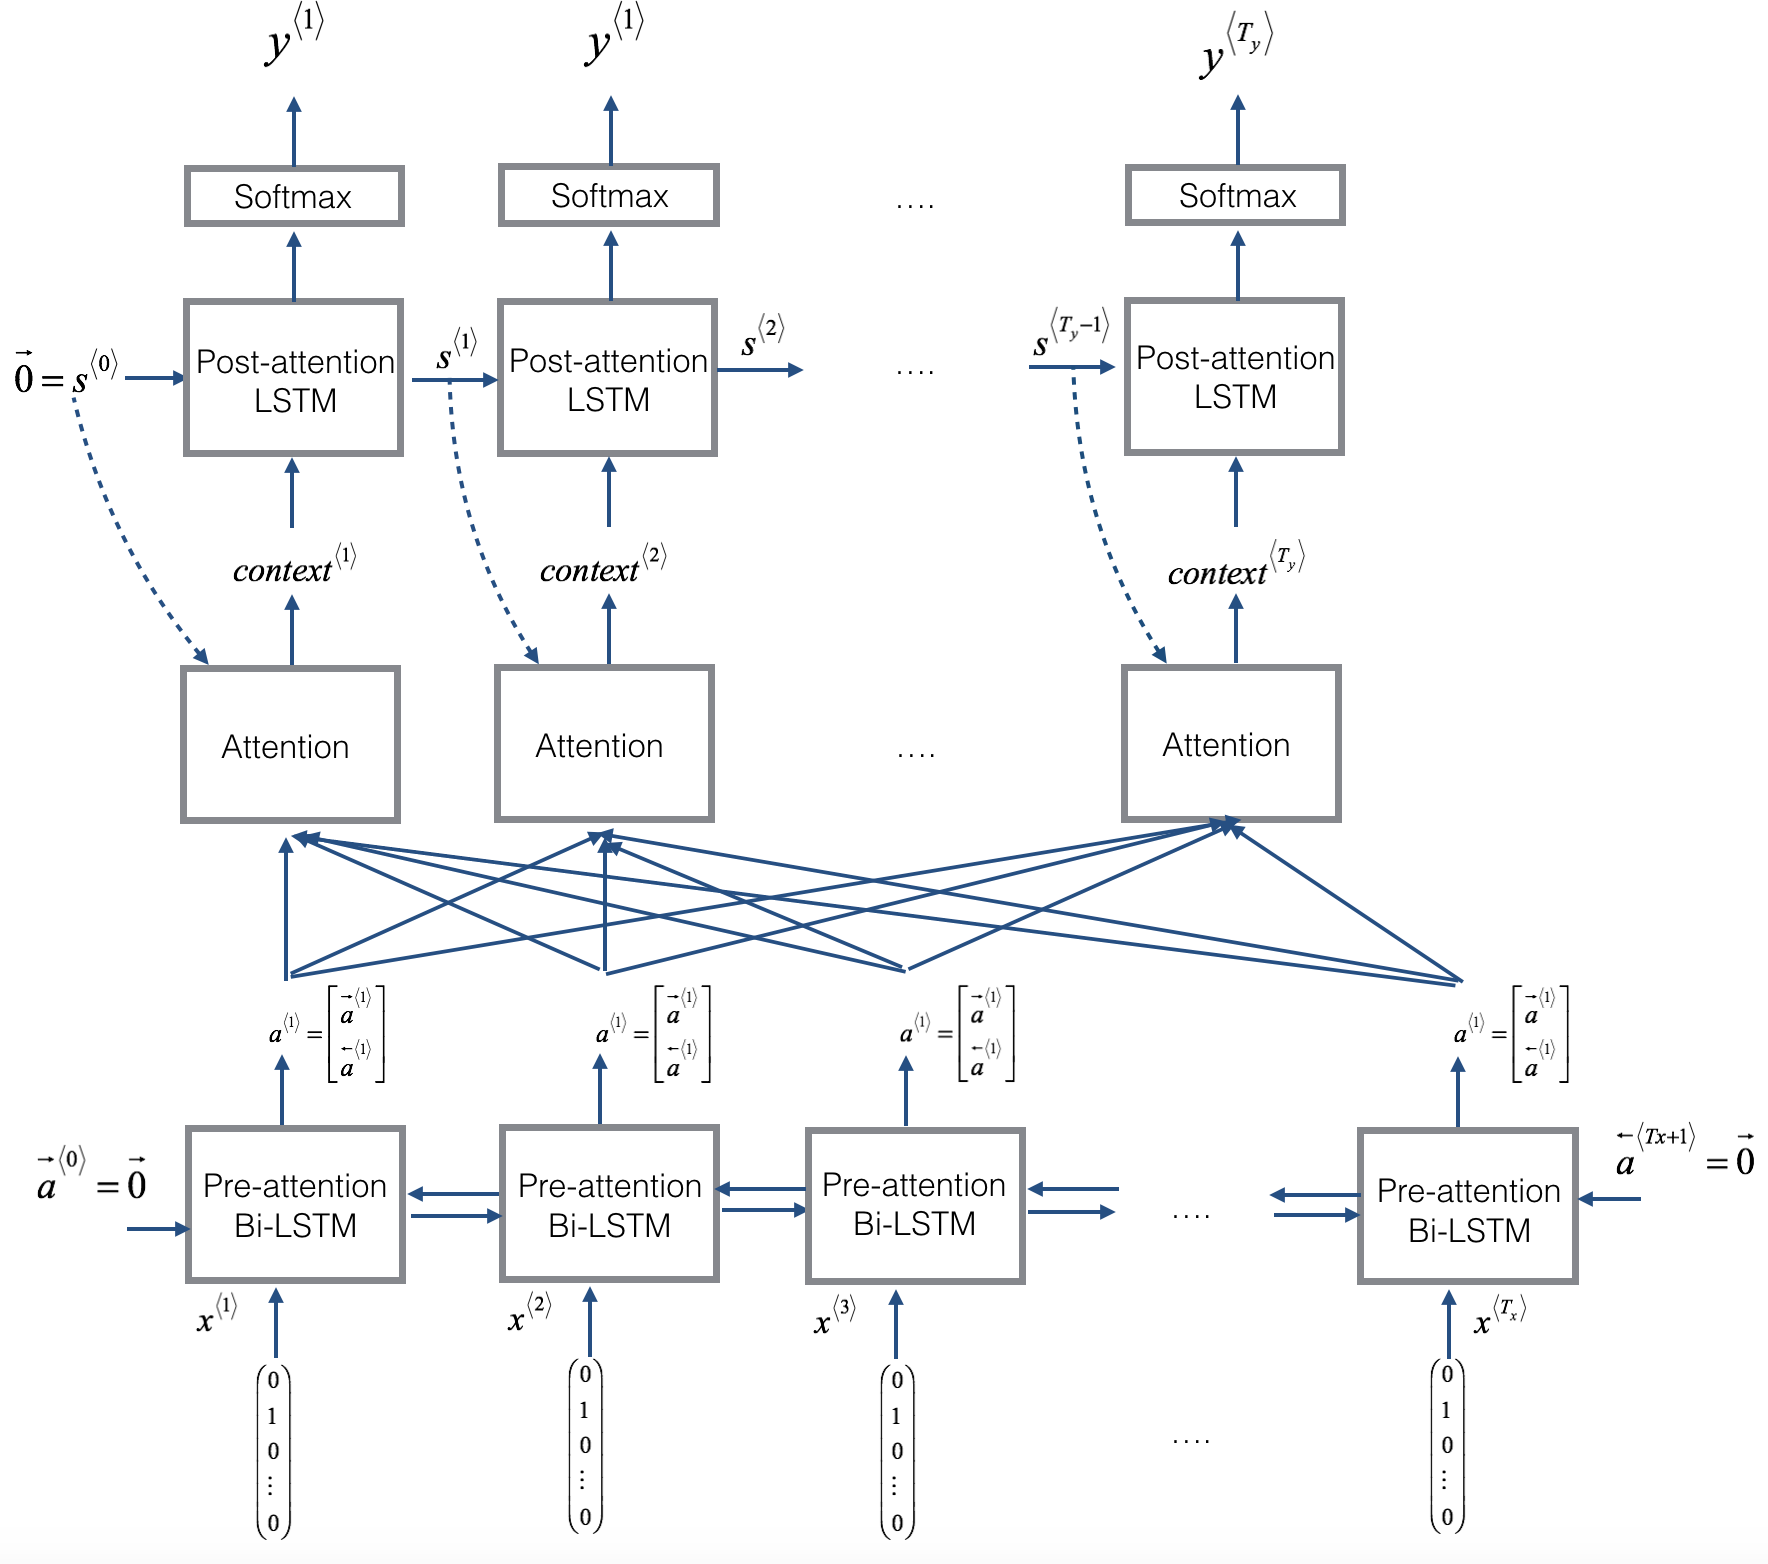

In [8]:
n_a = 64
n_s = 128
post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(vietnam_vocab), activation=softmax)
def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    outputs = []
    
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    for t in range(Ty):
    
        context = one_step_attention(a, s)
        
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        out = output_layer(s)
        
        outputs.append(out)
    
    model = Model([X, s0, c0], outputs)
    
    return model
model = model(Tx, Ty, n_a, n_s, len(japan_vocab), len(vietnam_vocab))

In [9]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 70, 281)]    0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 128)]        0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 70, 128)      177152      input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 70, 128)      0           s0[0][0]                         
                                                                 lstm_4[0][0]          

In [10]:
opt = Adam(lr = 0.02, beta_1=0.9, beta_2=0.999, decay = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
s0 = np.zeros((198, n_s))
c0 = np.zeros((198, n_s))
outputs = list(Yoh.swapaxes(0,1))
history = model.fit([Xoh, s0, c0], outputs, epochs=20, batch_size=20)

Epoch 1/20
10/10 [==============================] - 2s 160ms/step - loss: 144.5802 - dense_3_loss: 3.7330 - dense_3_1_loss: 5.2638 - dense_3_2_loss: 4.4808 - dense_3_3_loss: 3.5526 - dense_3_4_loss: 4.4280 - dense_3_5_loss: 4.4946 - dense_3_6_loss: 4.5414 - dense_3_7_loss: 4.2300 - dense_3_8_loss: 4.5019 - dense_3_9_loss: 4.6343 - dense_3_10_loss: 4.5663 - dense_3_11_loss: 4.4769 - dense_3_12_loss: 4.6934 - dense_3_13_loss: 4.1627 - dense_3_14_loss: 4.1309 - dense_3_15_loss: 4.1172 - dense_3_16_loss: 4.1930 - dense_3_17_loss: 4.0951 - dense_3_18_loss: 4.0725 - dense_3_19_loss: 3.7731 - dense_3_20_loss: 3.3444 - dense_3_21_loss: 3.4009 - dense_3_22_loss: 2.8353 - dense_3_23_loss: 2.5320 - dense_3_24_loss: 2.3947 - dense_3_25_loss: 2.2947 - dense_3_26_loss: 2.1833 - dense_3_27_loss: 2.0910 - dense_3_28_loss: 2.1286 - dense_3_29_loss: 1.9507 - dense_3_30_loss: 1.7246 - dense_3_31_loss: 1.6871 - dense_3_32_loss: 1.5125 - dense_3_33_loss: 1.4553 - dense_3_34_loss: 1.3861 - dense_3_35_loss: 

Now i plot to see how loss decrease

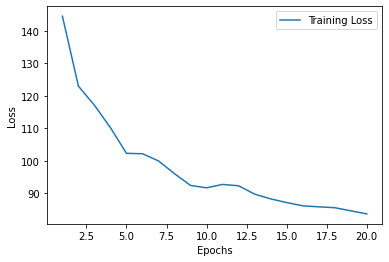

In [11]:
import matplotlib.pyplot as plt
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

I have run this model for longer, and saved the weights. Now let's load the weight and test it on some examples.

In [12]:
model.load_weights('my_model_weights.h5')

In [13]:
EXAMPLES = [u'あのイヌは大きい。','私は犬を飼っている。','本を閉じなさい。']

for example in EXAMPLES:
    
    source = np.array([string_to_int(example, Tx, japan_vocab)])
    
    source = np.where(source.astype(str)=='<unk>', 0, source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(japan_vocab)), source)))
    
    s0 = np.zeros((1, n_s)) #LSTM cells must have the same number of rows as there are training examples
    c0 = np.zeros((1, n_s))
    prediction = model([source, s0, c0],training = False)
    
    prediction = np.argmax(prediction, axis = -1)
    
    output = [inv_vietnam_vocab[int(i)] for i in prediction]
    output = list(filter(lambda a: a != '<pad>', output))
    print("source:", example)
    print("output:", ''.join(output))

source: あのイヌは大きい。
output: con chó đó lớn .
source: 私は犬を飼っている。
output: tôi có một con chó .
source: 本を閉じなさい。
output: đóng sách .
